In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import pickle

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models
from sklearn.preprocessing import StandardScaler

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [3]:
import PIL
print(PIL.__version__)

11.0.0


In [85]:

transform_train = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),  
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  

import torchvision
import torchvision.transforms as transforms

trainset = torchvision.datasets.CIFAR10(
    root='./data2',
    train=True,
    download=True,
    transform=transform_train  
)

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=64,
    shuffle=True,  
    num_workers=2  
)

testset = torchvision.datasets.CIFAR10(
    root='./data2',
    train=False,
    download=True,
    transform=transform_test  
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=64,
    shuffle=False, 
)

data_iter = iter(trainloader)
images, labels = next(data_iter)

print(f"Форма изображений: {images.shape}")  
print(f"Форма меток: {labels.shape}")  

Files already downloaded and verified
Files already downloaded and verified
Форма изображений: torch.Size([64, 3, 224, 224])
Форма меток: torch.Size([64])


In [118]:
model = models.alexnet(pretrained=True)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [121]:
model.features[10:]

Sequential(
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [122]:
# Замораживаем все параметры
for param in model.features.parameters():
    param.requires_grad = False

# Размораживаем последние 3 слоя в features
for idx, param in enumerate(model.features[10:].parameters()):
    param.requires_grad = True

In [125]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

features.0.weight: requires_grad=False
features.0.bias: requires_grad=False
features.3.weight: requires_grad=False
features.3.bias: requires_grad=False
features.6.weight: requires_grad=False
features.6.bias: requires_grad=False
features.8.weight: requires_grad=False
features.8.bias: requires_grad=False
features.10.weight: requires_grad=True
features.10.bias: requires_grad=True
classifier.0.weight: requires_grad=True
classifier.0.bias: requires_grad=True
classifier.1.weight: requires_grad=True
classifier.1.bias: requires_grad=True
classifier.3.weight: requires_grad=True
classifier.3.bias: requires_grad=True
classifier.4.weight: requires_grad=True
classifier.4.bias: requires_grad=True
classifier.6.weight: requires_grad=True
classifier.6.bias: requires_grad=True
classifier.7.weight: requires_grad=True
classifier.7.bias: requires_grad=True
classifier.9.weight: requires_grad=True
classifier.9.bias: requires_grad=True
classifier.10.weight: requires_grad=True
classifier.10.bias: requires_grad

In [124]:
model.classifier = nn.Sequential(
    nn.Linear(in_features=9216, out_features=4096, bias=True),
    nn.BatchNorm1d(4096),
    nn.ReLU(inplace=True),                
    nn.Linear(4096, 2048),  
    nn.BatchNorm1d(2048),
    nn.ReLU(inplace=True),                              
    nn.Linear(2048, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(inplace=True),                             
    nn.Linear(1024, 512), 
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),            
    nn.Linear(512, 10)                
)
model = model.to(device)

print(f"Изменённая архитектура классификатора:\n{model.classifier}")

Изменённая архитектура классификатора:
Sequential(
  (0): Linear(in_features=9216, out_features=4096, bias=True)
  (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=4096, out_features=2048, bias=True)
  (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=2048, out_features=1024, bias=True)
  (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): Linear(in_features=1024, out_features=512, bias=True)
  (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): Linear(in_features=512, out_features=10, bias=True)
)


In [126]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()  
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2, weight_decay = 0.01)

In [127]:
def train_model(model, trainloader, testloader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in tqdm(trainloader, desc=f"Эпоха {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(trainloader)
        train_losses.append(epoch_loss)

        model.eval()
        running_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(testloader)
            test_losses.append(epoch_loss)

    return train_losses, test_losses


In [131]:
def evaluate_model(model, test_loader, device):
    model.eval()  
    correct, total = 0, 0

    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Точность на тестовом наборе: {accuracy:.2f}%")
    return accuracy

In [128]:
for X, y in trainloader:
    print(X[0].size())
    break

torch.Size([3, 224, 224])


In [129]:
train_losses, test_losses = train_model(model, trainloader, testloader, criterion, optimizer, device, num_epochs=10)

Эпоха 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:35<00:00, 22.26it/s]


In [133]:
#Точность для лучшей модели
evaluate_model(model, testloader, device)

Точность на тестовом наборе: 88.00%


88.0

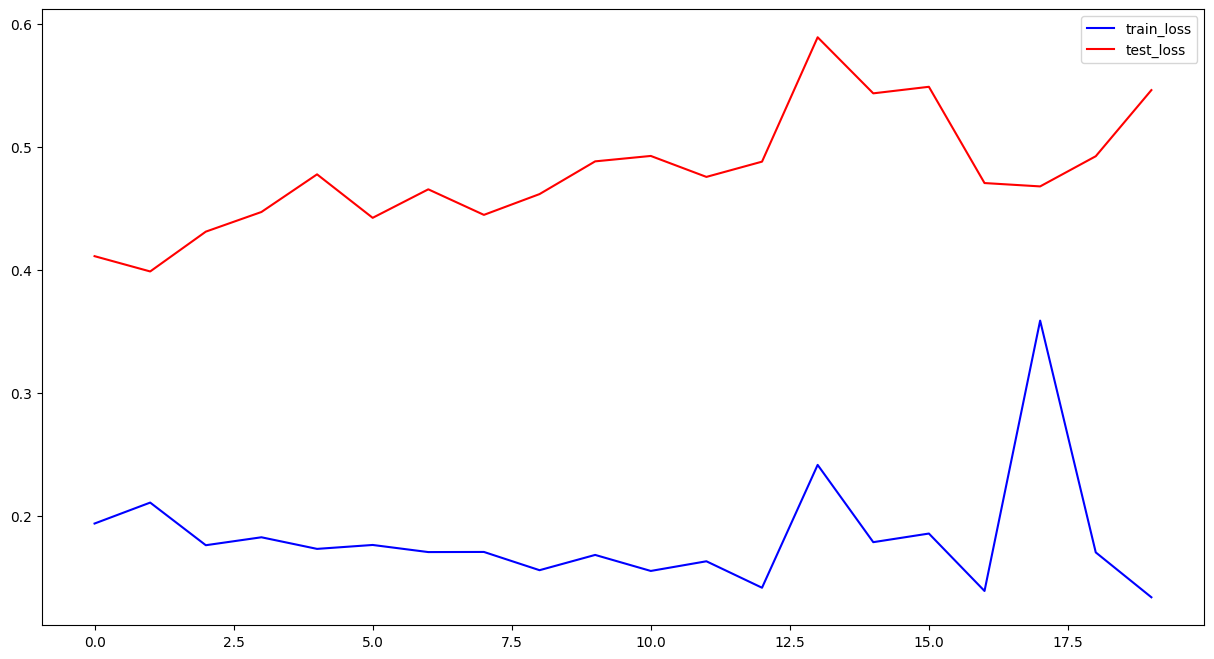

In [99]:
#Это вариант на 20 эпохах с dropout classificator
plt.figure(figsize = (15, 8))

plt.plot(list(range(20)), train_losses, color = 'b', label = 'train_loss')
plt.plot(list(range(20)), test_losses, color = 'r', label = 'test_loss')

plt.legend()

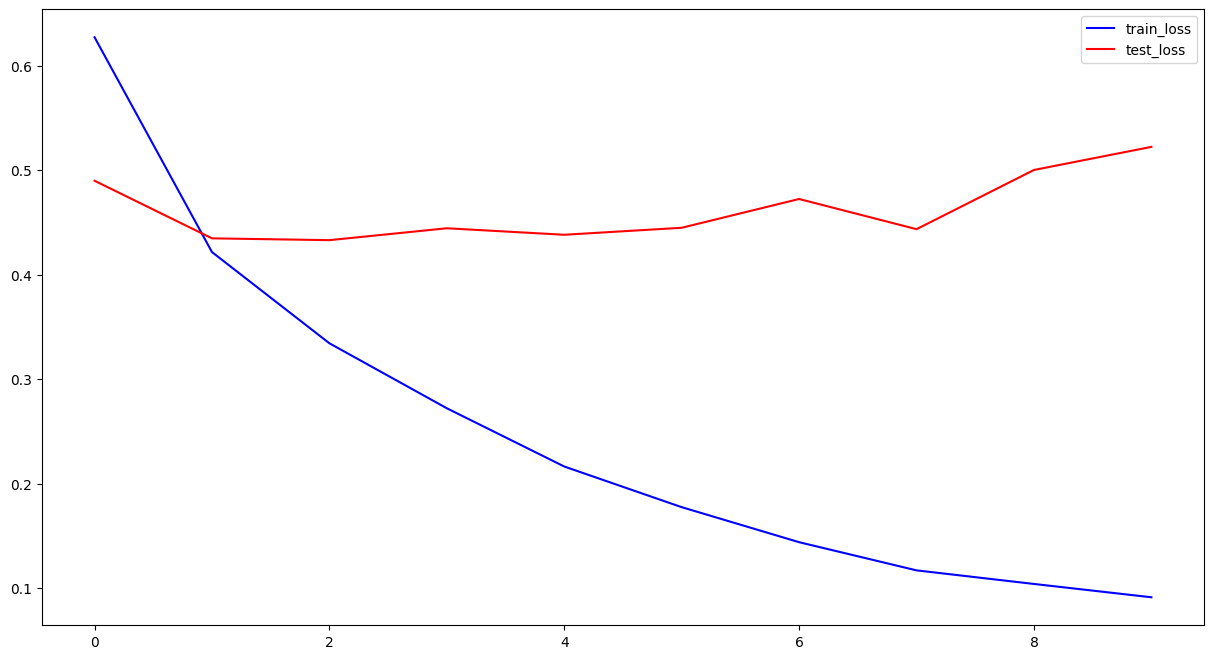

In [111]:
#Это новый вариант где все features заморожены и измененный классификатор
plt.figure(figsize = (15, 8))

plt.plot(list(range(10)), train_losses, color = 'b', label = 'train_loss')
plt.plot(list(range(10)), test_losses, color = 'r', label = 'test_loss')

plt.legend()

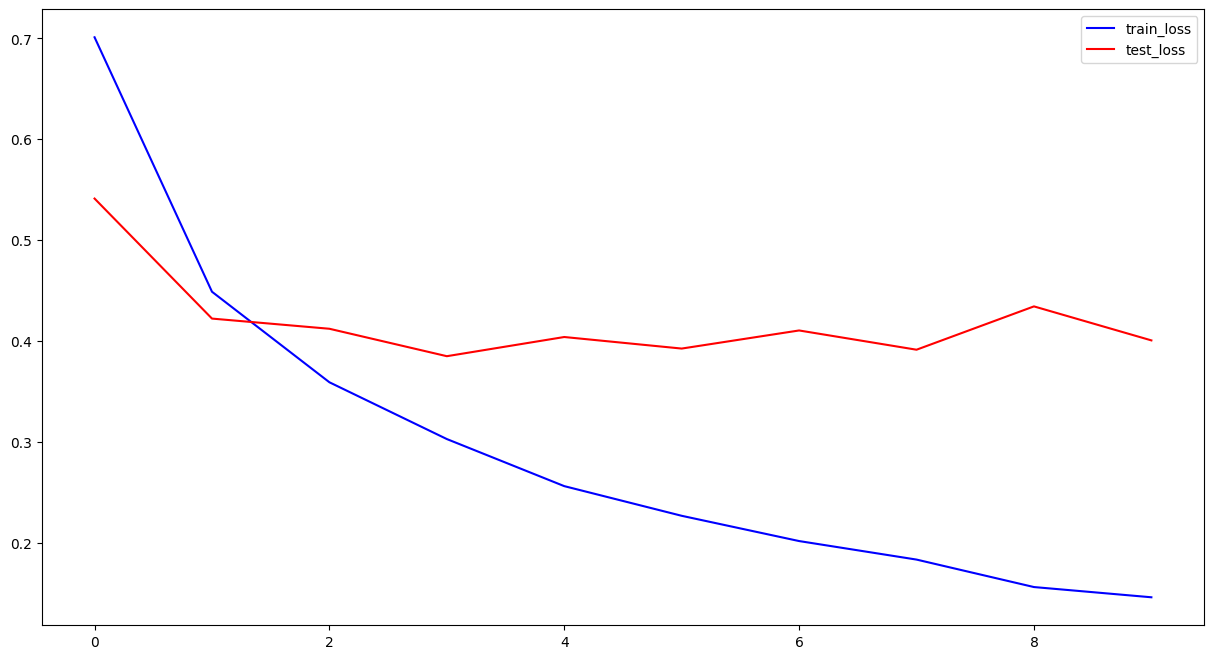

In [130]:
#Тут разморожено 4 последних слоя и измененный классификатор - лучший вариант
plt.figure(figsize = (15, 8))

plt.plot(list(range(10)), train_losses, color = 'b', label = 'train_loss')
plt.plot(list(range(10)), test_losses, color = 'r', label = 'test_loss')

plt.legend()

In [135]:
#Теперь возьмeм модель покруче

model2 = models.resnet34(pretrained=True)
num_classes = 10  
model2.fc = nn.Linear(model2.fc.in_features, num_classes)  
model2 = model2.to(device)

/home/rosneft/projects/pr4/venv4/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/rosneft/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:01<00:00, 49.5MB/s]


In [153]:
criterion = nn.CrossEntropyLoss()  
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-3, weight_decay = 0.01)  

In [155]:
def train_model(model, trainloader, testloader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in tqdm(trainloader, desc=f"Эпоха {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct / total

        model.eval()
        running_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        test_loss = running_loss / len(testloader)
        test_losses.append(test_loss)
        test_accuracy = 100 * correct / total
        print(f"Эпоха {epoch+1}:")
        print(f"  Потеря на обучении: {train_loss:.4f}, Точность на обучении: {train_accuracy:.2f}%")
        print(f"  Потеря на тесте: {test_loss:.4f}, Точность на тесте: {test_accuracy:.2f}%")

    return train_losses, test_losses

In [156]:
model2 = model2.to(device)
num_epochs = 10
train_losses, test_losses = train_model(
    model2, trainloader, testloader, criterion, optimizer, device, num_epochs=num_epochs
)

Эпоха 1/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:36<00:00, 21.35it/s]


Эпоха 1:
  Потеря на обучении: 0.4958, Точность на обучении: 83.92%
  Потеря на тесте: 0.3612, Точность на тесте: 88.24%


Эпоха 2/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:36<00:00, 21.54it/s]


Эпоха 2:
  Потеря на обучении: 0.3023, Точность на обучении: 89.99%
  Потеря на тесте: 0.3069, Точность на тесте: 89.55%


Эпоха 3/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:38<00:00, 20.19it/s]


Эпоха 3:
  Потеря на обучении: 0.2199, Точность на обучении: 92.65%
  Потеря на тесте: 0.3180, Точность на тесте: 89.79%


Эпоха 4/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:38<00:00, 20.48it/s]


Эпоха 4:
  Потеря на обучении: 0.1744, Точность на обучении: 94.14%
  Потеря на тесте: 0.2802, Точность на тесте: 90.85%


Эпоха 5/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.86it/s]


Эпоха 5:
  Потеря на обучении: 0.1384, Точность на обучении: 95.33%
  Потеря на тесте: 0.2690, Точность на тесте: 91.39%


Эпоха 6/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.67it/s]


Эпоха 6:
  Потеря на обучении: 0.1081, Точность на обучении: 96.39%
  Потеря на тесте: 0.2931, Точность на тесте: 91.15%


Эпоха 7/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:39<00:00, 20.00it/s]


Эпоха 7:
  Потеря на обучении: 0.0937, Точность на обучении: 96.88%
  Потеря на тесте: 0.3034, Точность на тесте: 90.73%


Эпоха 8/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.84it/s]


Эпоха 8:
  Потеря на обучении: 0.0766, Точность на обучении: 97.47%
  Потеря на тесте: 0.3291, Точность на тесте: 90.81%


Эпоха 9/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:38<00:00, 20.37it/s]


Эпоха 9:
  Потеря на обучении: 0.0694, Точность на обучении: 97.64%
  Потеря на тесте: 0.3089, Точность на тесте: 91.28%


Эпоха 10/10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [00:37<00:00, 20.63it/s]


Эпоха 10:
  Потеря на обучении: 0.0589, Точность на обучении: 98.06%
  Потеря на тесте: 0.3172, Точность на тесте: 91.54%


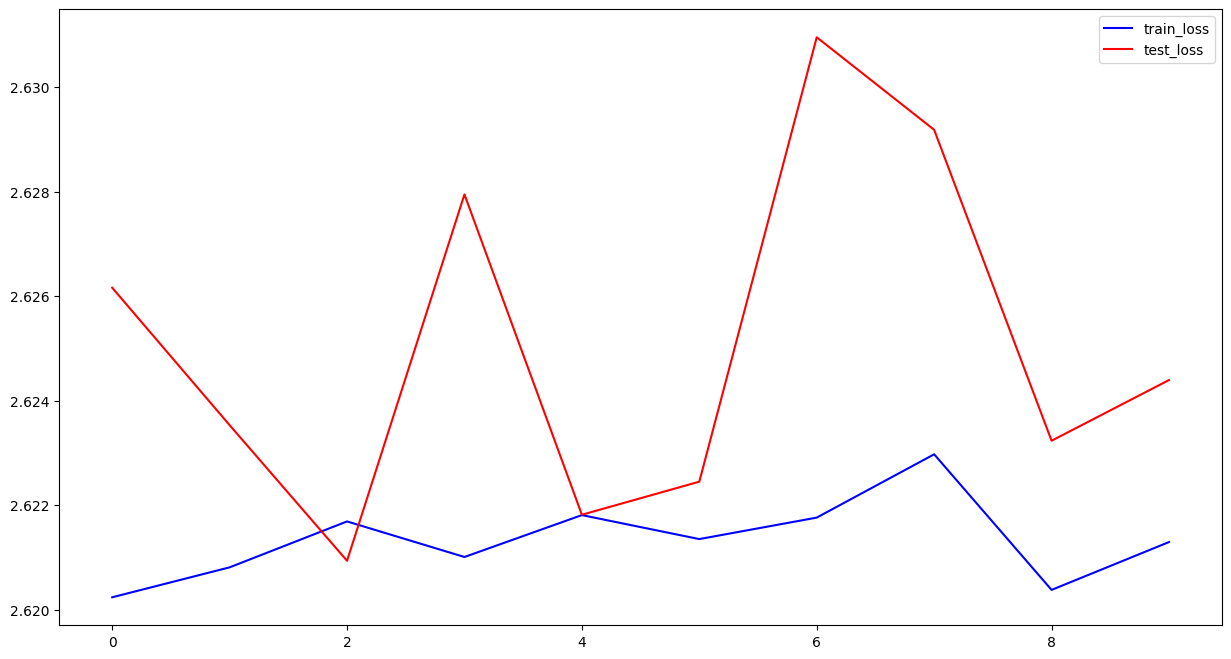

In [142]:
#Просто пропустили через модель, усложним классификатор
plt.figure(figsize = (15, 8))

plt.plot(list(range(10)), train_losses, color = 'b', label = 'train_loss')
plt.plot(list(range(10)), test_losses, color = 'r', label = 'test_loss')

plt.legend()

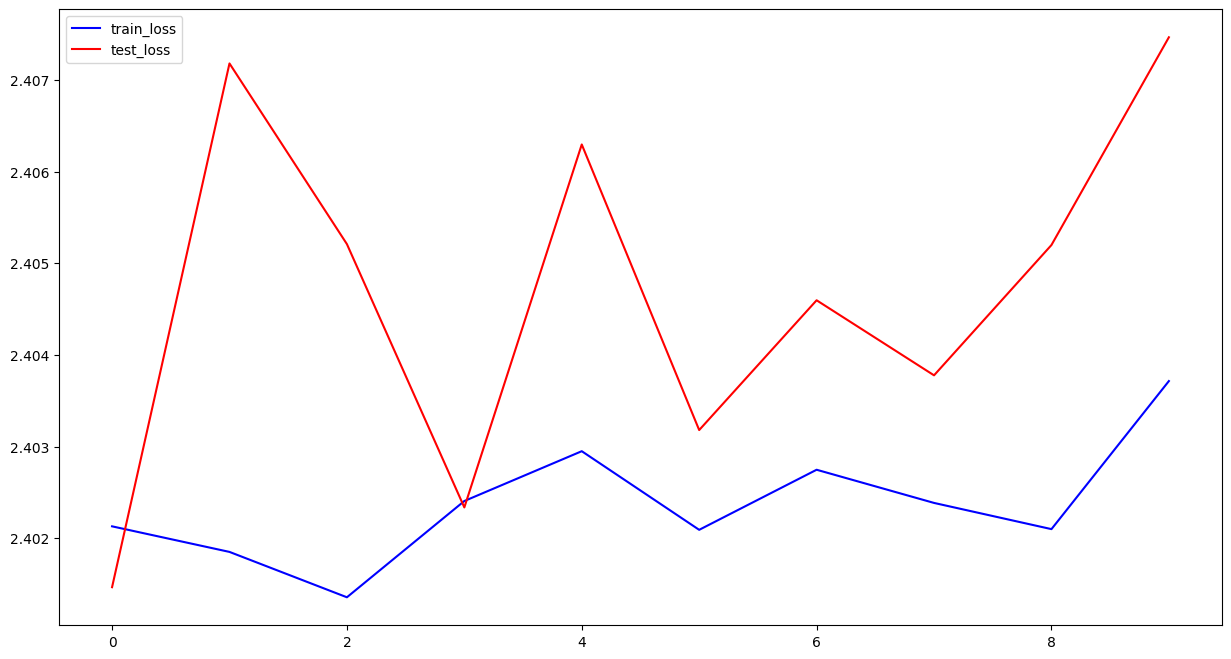

In [151]:
#Добавили слоев в классификатор
plt.figure(figsize = (15, 8))

plt.plot(list(range(10)), train_losses, color = 'b', label = 'train_loss')
plt.plot(list(range(10)), test_losses, color = 'r', label = 'test_loss')

plt.legend()

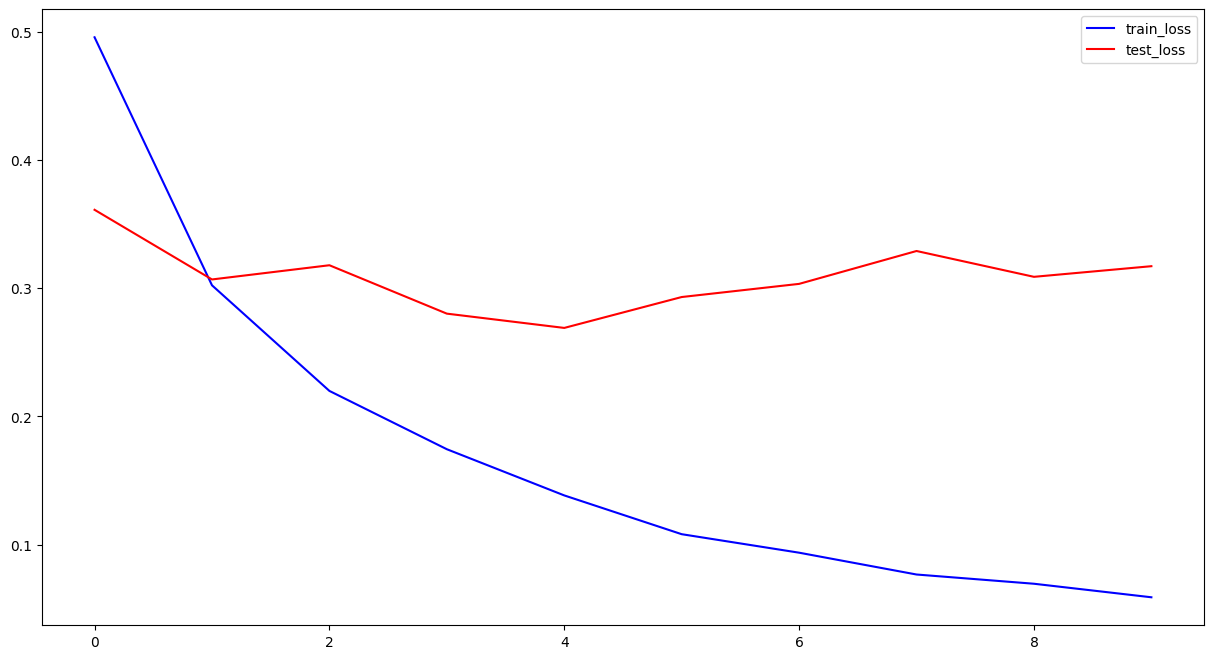

In [157]:
#Финальный результат - выглядит отлично (заморозила все слои кроме последнего и усложнила классификатор)
plt.figure(figsize = (15, 8))

plt.plot(list(range(10)), train_losses, color = 'b', label = 'train_loss')
plt.plot(list(range(10)), test_losses, color = 'r', label = 'test_loss')

plt.legend()

In [148]:
#Изменила архитектуру - заморозила все слои кроме 4х последних и собственный классификатор
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [143]:
model2.fc = nn.Sequential(
    nn.Linear(model2.fc.in_features, 256, bias=True),   
    nn.BatchNorm1d(256),                              
    nn.ReLU(inplace=True),                             
    nn.Linear(256, 128),                            
    nn.BatchNorm1d(128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 10)                                 
)

In [144]:
for param in model2.parameters():
    param.requires_grad = False

# Размораживаем последние 4 слоя: layer4, avgpool и fc
for param in model2.layer4.parameters():
    param.requires_grad = True

for param in model2.fc.parameters():
    param.requires_grad = True

In [147]:
# Функция для вывода статуса requires_grad для каждого слоя
def print_grad_status(model2):
    for name, param in model2.named_parameters():
        print(f"{name}: requires_grad={param.requires_grad}")
print_grad_status(model2)

conv1.weight: requires_grad=False
bn1.weight: requires_grad=False
bn1.bias: requires_grad=False
layer1.0.conv1.weight: requires_grad=False
layer1.0.bn1.weight: requires_grad=False
layer1.0.bn1.bias: requires_grad=False
layer1.0.conv2.weight: requires_grad=False
layer1.0.bn2.weight: requires_grad=False
layer1.0.bn2.bias: requires_grad=False
layer1.1.conv1.weight: requires_grad=False
layer1.1.bn1.weight: requires_grad=False
layer1.1.bn1.bias: requires_grad=False
layer1.1.conv2.weight: requires_grad=False
layer1.1.bn2.weight: requires_grad=False
layer1.1.bn2.bias: requires_grad=False
layer1.2.conv1.weight: requires_grad=False
layer1.2.bn1.weight: requires_grad=False
layer1.2.bn1.bias: requires_grad=False
layer1.2.conv2.weight: requires_grad=False
layer1.2.bn2.weight: requires_grad=False
layer1.2.bn2.bias: requires_grad=False
layer2.0.conv1.weight: requires_grad=False
layer2.0.bn1.weight: requires_grad=False
layer2.0.bn1.bias: requires_grad=False
layer2.0.conv2.weight: requires_grad=False
